# 1. Load and parse the data
#### Code is primarily from Lydia's FICO-figures.ipynb 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# import all of our files
import sys
sys.path.append('../')
import Liu_paper_code.fico as fico
import Liu_paper_code.distribution_to_loans_outcomes as dlo
from scripts.data_creation_utils import get_pmf,get_repay_probabilities,get_scores, adjust_set_ratios
from scripts.evaluation_utils import inspect_MinMax
from scripts.visualization_utils import visualize_data_distribution, visual_scores_by_race, visual_repay_dist
# imports for my own code
import pandas as pd
import random
from random import choices



In [3]:
# Parameters
data_dir = '../data/raw/'
results_dir = '../data/synthetic_ds/'
file_name = 'test.csv'
set_size = 100000

group_size_ratio = [0.12,0.88]
black_label_ratio = [0.66,0.34]

order_of_magnitude = 50000
shuffle_seed = 42
round_num_scores = 2

In [4]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir);

In [5]:
cdfs = all_cdfs[["White","Black"]]

# B is White
# A is Black

cdf_B = cdfs['White'].values
cdf_A = cdfs['Black'].values

repay_B = performance['White']
repay_A = performance['Black']
scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index


In [6]:
# basic parameters
N_scores = cdf_B.size
N_groups = 2

# get probability mass functions of each group
pi_A = get_pmf(cdf_A)
pi_B = get_pmf(cdf_B)
pis = np.vstack([pi_A, pi_B])

# demographic statistics 
#group_ratio = np.array((totals["Black"], totals["White"]))
#group_size_ratio = group_ratio/group_ratio.sum() - true fico data goup size ratio
#print(group_size_ratio)

In [7]:
# to get loan repay probabilities for a given score
loan_repaid_probs = [lambda i: repay_A[scores[scores.get_loc(i,method='nearest')]], 
                     lambda i: repay_B[scores[scores.get_loc(i,method='nearest')]]]

# unpacking repay probability as a function of score
loan_repay_fns = [lambda x: loan_repaid_prob(x) for
                      loan_repaid_prob in loan_repaid_probs]

## 2.1 Convert the data in format needed
The parameter round_num designates if we will round the credit scores and/or probabilities to a certain degree.<br> 
round_num = {0,1,2} <br> 
* 0: don't round at all (we don't recommend this) <br>
* 1: round to the hundreth decimal <br>
* 2: round to the nearest integer (no decimals left)

In [8]:
# Make repay probabilities into percentages from decimals
# NOTE: A is Black, B is White
scores_arr = np.asarray(get_scores(scores=scores_list, round_num=round_num_scores)) # we recommend 1 or 2 for round_num
print(scores_arr)
repay_A_arr = pd.Series.to_numpy(repay_A)*100
repay_B_arr = pd.Series.to_numpy(repay_B)*100

[300. 312. 324. 336. 348. 355. 361. 367. 373. 379. 385. 390. 396. 402.
 406. 411. 416. 420. 425. 430. 434. 439. 444. 448. 452. 456. 460. 464.
 468. 472. 475. 479. 483. 487. 491. 495. 498. 502. 505. 508. 511. 515.
 518. 521. 524. 527. 530. 534. 537. 540. 543. 546. 549. 552. 555. 557.
 560. 562. 565. 568. 570. 573. 576. 578. 581. 583. 586. 589. 591. 594.
 596. 599. 601. 603. 605. 608. 610. 612. 614. 616. 618. 620. 622. 624.
 626. 628. 630. 632. 635. 637. 639. 641. 643. 645. 647. 649. 651. 653.
 655. 657. 658. 660. 662. 664. 666. 667. 669. 671. 673. 675. 676. 678.
 680. 682. 684. 686. 687. 689. 691. 693. 695. 696. 698. 700. 701. 703.
 704. 706. 707. 709. 710. 712. 713. 715. 716. 718. 719. 721. 722. 724.
 725. 726. 728. 729. 731. 734. 735. 737. 738. 740. 741. 743. 744. 746.
 749. 750. 752. 753. 755. 756. 758. 759. 761. 763. 764. 766. 767. 769.
 771. 772. 774. 775. 777. 778. 780. 782. 783. 785. 786. 788. 790. 791.
 793. 796. 797. 799. 802. 806. 811. 815. 819. 824. 828. 832. 837. 841.
 846. 

## 2.2/3 Sample from the data and Combine the scores and probabilities and convert data types
We use round_num with a value of 1 so that we have two decimals for the probabilities. We think rounding to the nearest integer would lead to us losing important data. 

In [9]:
def sample(group_size_ratio, order_of_magnitude, shuffle_seed,scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr):
    
        # Sample data according to the pmf
    # Reference: https://www.w3schools.com/python/ref_random_choices.asp

    num_A_samples = int(group_size_ratio[0] * order_of_magnitude)
    num_B_samples = int(group_size_ratio[1] * order_of_magnitude)

    samples_A = np.asarray(sorted(choices(scores_arr, pi_A, k=num_A_samples)))
    samples_B = np.asarray(sorted(choices(scores_arr, pi_B, k=num_B_samples)))

    # Calculate samples groups' probabilities and make arrays for race

    # A == Black == 0 (later defined as 0.0 when converting to pandas df)
    samples_A_probs = get_repay_probabilities(samples=samples_A,scores_arr=scores_arr, repay_probs=repay_A_arr, round_num=1)
    samples_A_race = np.zeros(num_A_samples, dtype= int)
    # B == White == 1 (later defined as 1.0 when converting to pandas df)
    samples_B_probs = get_repay_probabilities(samples=samples_B,scores_arr=scores_arr, repay_probs=repay_B_arr, round_num=1)
    samples_B_race = np.ones(num_B_samples, dtype= int)

    # Get data in dict form with score and repay prob
    data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs} #,'race': samples_A_race}
    data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs} #,'race': samples_B_race}

    # Get data in dict form with score, repay prob, and race
    data_A_dict = {'score': samples_A, 'repay_probability': samples_A_probs ,'race': samples_A_race}
    data_B_dict = {'score': samples_B, 'repay_probability': samples_B_probs,'race': samples_B_race}

    # Convert from dict to df
    data_A_df = pd.DataFrame(data=data_A_dict, dtype=np.float64)
    data_B_df = pd.DataFrame(data=data_B_dict, dtype=np.float64)

    # Combine all of the data together and shuffle
    # NOTE: not currently being used but could be useful at a later time
    data_all_df = pd.concat([data_A_df, data_B_df], ignore_index=True)
    #print(data_all_df)
    np.random.seed(shuffle_seed)
    data_all_df_shuffled = data_all_df.sample(frac=1).reset_index(drop=True)
    #print(data_all_df_shuffled)

    # Add Final Column to dataframe, repay indices
    # repay: 1.0, default: 0.0
    probabilities = data_all_df_shuffled['repay_probability']
    repay_indices = []
    # Create a random num and then have that decide given a prob if the person gets a loan or not
    # (e.g. If 80% prob, then calculate a random num, then if that is below they will get loan, if above, then they don't)

    for index, prob in enumerate(probabilities):
        rand_num = random.randint(0,1000)/10
        if rand_num > prob:  # default
            repay_indices.append(0)
        else:
            repay_indices.append(1)  # repay

    data_all_df_shuffled['repay_indices'] = np.array(repay_indices)

    return data_all_df_shuffled, samples_A, samples_B, samples_A_probs, samples_B_probs

In [10]:
# Sample data according to the pmf
# Reference: https://www.w3schools.com/python/ref_random_choices.asp
# Calculate samples groups' probabilities and make arrays for race
# A == Black == 0 (later defined as 0.0 when converting to pandas df)
# B == White == 1 (later defined as 1.0 when converting to pandas df)

# generate first batch of samples:
data,samples_A, samples_B, samples_A_probs, samples_B_probs = sample(group_size_ratio, order_of_magnitude,shuffle_seed, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
# split the data cols (x,y)
x = data[['score','repay_probability', 'race']].values
y = data['repay_indices'].values

# adjust the set according to the ratios specified
x,y = adjust_set_ratios(x, y, black_label_ratio, group_size_ratio, set_size)
idx_An = np.where((x[:, 2] == 0) & (y == 0))[0]
idx_Ap = np.where((x[:, 2] == 0) & (y == 1))[0]
idx_B = np.where((x[:, 2] == 1))[0]
i = 1
# merge x,y back into a DataFrame
df = {'score':x[:,0],'repay_probability': x[:,1],'race':x[:,2],'repay_indices': y}
data = pd.DataFrame(df)

# if dataset it to small, samplee a larger batch
while len(y) < set_size:
    i += 1
    # Generate new samples
    data_add, samples_A_add, samples_B_add, samples_A_probs_add, samples_B_probs_add = sample(group_size_ratio, order_of_magnitude,i, scores_arr, pi_A, pi_B, repay_A_arr, repay_B_arr)
    data = pd.concat([data,data_add])
    samples_A = np.concatenate((samples_A,samples_A_add))
    samples_A_probs = np.concatenate((samples_A_probs,samples_A_probs_add))
    samples_B = np.concatenate((samples_B,samples_B_add))
    samples_B_probs = np.concatenate((samples_B_probs,samples_B_probs_add))
    # split the data cols (x,y)
    x = data[['score','repay_probability', 'race']].values
    y = data['repay_indices'].values

    # adjust the set according to the ratios specified
    x,y = adjust_set_ratios(x,y, black_label_ratio, group_size_ratio, set_size)
    idx_An = np.where((x[:, 2] == 0) & (y == 0))[0]
    idx_Ap = np.where((x[:, 2] == 0) & (y == 1))[0]
    idx_B = np.where((x[:, 2] == 1))[0]
    # merge x,y back into a DataFrame
    df = {'score':x[:,0],'repay_probability': x[:,1],'race':x[:,2],'repay_indices': y}
    data = pd.DataFrame(df)

# print proportions of dataset
print(i,'Black N/P:',len(idx_An),'/',len(idx_Ap),'White:',len(idx_B))

3 Black N/P: 7920 / 4080 White: 88000


## 2.4 Save the pandas dataframes to CSVs

In [11]:
data.to_csv(index=False, path_or_buf=results_dir+file_name)

# To save the data separately by race
#data_A_df.to_csv(index=False, path_or_buf='simData_2decProbs_0decScores_groupA_black.csv')
#data_B_df.to_csv(index=False, path_or_buf='simData_2decProbs_0decScores_groupB_white.csv')

## 2.5 Inspect the min/max values of the data

In [12]:
# TODO: make a function for printing the min/max values of the respective groups for score and probability

In [13]:
inspect_MinMax(samples_A_probs,samples_B_probs)

the range of the Group A (Black) repay probabilities is:  98.49
the min value is:  0.33
the max value is:  98.82
the range of the Group B (White) repay probabilities is:  97.64
the min value is:  1.46
the max value is:  99.1


In [14]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

total_samples_A = len(samples_A)
total_samples_B = len(samples_B)
values_A = set(samples_A)
values_B = set(samples_B)
res_A = Counter(samples_A)
res_B = Counter(samples_B)

pmf_A = []
pmf_B = []
for v_A,v_B in zip(values_A,values_B):
    pmf_A.append(res_A[v_A]/total_samples_A)
    pmf_B.append(res_B[v_B]/total_samples_B)
    

count1 = 0
count2 = 0
for e1,e2 in zip(pmf_A,pmf_B):
    if e1 < 1/550:
        count1 += 1
    if e2 < 1/550:
        count2 += 1
    
print('Ratio:',count1/len(pmf_A), count2/len(pmf_B))

Ratio: 0.3401015228426396 0.02030456852791878


In [15]:
### Masuring the amount of points <1%
count1 = 0
count2 = 0
for e1,e2 in zip(samples_A_probs,samples_B_probs):
    if e1 < 1:
        count1 += 1
    if e2 < 1:
        count2 += 1
    
print('Ratio:',count1/len(samples_A_probs), count2/len(samples_B_probs))

Ratio: 0.011444444444444445 0.0


## 2.6 Visualize the data

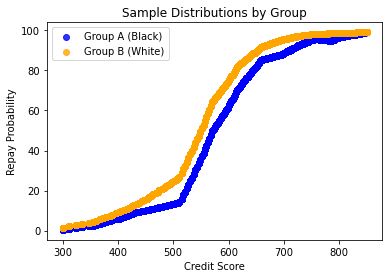

In [16]:
visualize_data_distribution(results_dir,samples_A,samples_A_probs,samples_B,samples_B_probs)

In [17]:
#visual_scores_by_race(data)

In [18]:
#visual_repay_dist(data)